In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal
import pandas as pd

Import our SIE data set, which we saved as a .csv file.  Use the head command to show all of our data. 

In [2]:
model_name = 'ecmwfsipn'
model_type = 'reforecast'
no_day_change = 5
filepath = '/home/disk/sipn/mcmcgraw/data/VRILE/'
filename = filepath+'{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=model_name,
                       model_type=model_type,d_days=no_day_change)
SIE_data = pd.read_csv(filename)
SIE_data = SIE_data.dropna()
SIE_data.head()

,Unnamed: 0,I (init date),V (valid date),SIE,lead time (days),d_SIE (V - I),ensemble,region
0,0,1993-01-01,1993-01-03,13.261036,2.0,0.046306,1.0,panArctic
1,1,1993-01-01,1993-01-04,13.268475,3.0,-0.003511,1.0,panArctic
2,2,1993-01-01,1993-01-05,13.230590,4.0,-0.003011,1.0,panArctic
3,3,1993-01-01,1993-01-06,13.224993,5.0,0.020101,1.0,panArctic
4,4,1993-01-01,1993-01-07,13.258025,6.0,0.077908,1.0,panArctic


Make histograms grouped by region, lead day, and valid date. Start with regions.  Use groupby to group dataframe by regions, and unique() to get the list of regions

In [3]:
region_names = SIE_data['region'].dropna().unique().tolist()
region_ind_test = 15
region_name_test = region_names[region_ind_test]
SIE_region_groupby = SIE_data.groupby(['region'])
SIE_by_region = SIE_region_groupby.get_group(region_name_test)

Now select for month of valid date (JJAS for now)

In [29]:
valid_dates = pd.to_datetime(SIE_by_region['V (valid date)'])
valid_days_months = pd.to_datetime(SIE_by_region['V (valid date)']).dt.month
#SIE_valid_groupby = SIE_by_region.groupby(['V (valid date)'])
month_sel = [6,7,8,9]
month_sel_str = 'JJAS'
#choose_by_month = SIE_data['V (valid date)'].isin((valid_days_months,month_sel))
#print(valid_days_months)
f_month = np.isin(valid_days_months.values,month_sel)
SIE_month_trim = SIE_by_region.loc[f_month]

Now, filter by lead date.  We'll start with lead times of 1-4 weeks

In [30]:
SIE_lead_groups = SIE_month_trim.groupby(['lead time (days)'])
lead_days_select = [7,14,21,28]
lead_days_ind = 0
SIE_lead_sel = SIE_lead_groups.get_group(lead_days_select[0])
is_detrend = False
if is_detrend == True:
    SIE_dt = signal.detrend(SIE_lead_sel['SIE'])
    SIE_lead_sel['SIE'] = SIE_dt
#plt.plot(SIE_lead_sel['SIE'])
#plt.plot(SIE_lead_sel['SIE'],color='r')

Remove seasonality.  We'll just do it by month--remove mean of all June days from each June day, etc. Add a new column to the existing dataframe with seasonal anomalies of SIE, and one with seasonal anomalies of the change in SIE

In [31]:
SIE_seas_rem = np.array([])
d_SIE_seas_rem = np.array([])
valid_months_lead_sel = pd.to_datetime(SIE_lead_sel['V (valid date)']).dt.month
valid_dates_lead_sel = pd.to_datetime(SIE_lead_sel['V (valid date)'])
for i_SIE in np.arange(0,len(SIE_lead_sel)):
#i_SIE = 100
#print(valid_months_lead_sel.iloc[0])
    mon_i = valid_months_lead_sel.iloc[i_SIE]
    all_mon_i = np.where(valid_months_lead_sel == mon_i)
    i_ice = SIE_lead_sel['SIE'].iloc[i_SIE] - SIE_lead_sel['SIE'].iloc[all_mon_i].mean()
    i_d_ice = SIE_lead_sel['d_SIE (V - I)'].iloc[i_SIE] - SIE_lead_sel['d_SIE (V - I)'].iloc[all_mon_i].mean()
    SIE_seas_rem = np.append(SIE_seas_rem,i_ice)
    d_SIE_seas_rem = np.append(d_SIE_seas_rem,i_d_ice)
print(SIE_seas_rem)
print(d_SIE_seas_rem)
SIE_lead_sel['SIE (seas rem)'] = SIE_seas_rem
SIE_lead_sel['d_SIE (seas rem)'] = d_SIE_seas_rem
SIE_lead_sel.head()

[ 0.05584205  0.03607698  0.04850226 ... -0.06835037 -0.04945846
 -0.04690633]
[ 0.04341333  0.03444155  0.01751152 ... -0.02056549 -0.03408089
 -0.0179952 ]


/home/disk/sipn/mcmcgraw/anaconda3/envs/VRILE_environment/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/disk/sipn/mcmcgraw/anaconda3/envs/VRILE_environment/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,I (init date),V (valid date),SIE,lead time (days),d_SIE (V - I),ensemble,region,SIE (seas rem),d_SIE (seas rem)
23246880,5,1993-06-01,1993-06-08,1.648431,7.0,0.015500,1.0,Kara-Laptev,0.055842,0.043413
23247091,216,1993-06-01,1993-06-08,1.628665,7.0,0.006528,2.0,Kara-Laptev,0.036077,0.034442
23247302,427,1993-06-01,1993-06-08,1.641091,7.0,-0.010402,3.0,Kara-Laptev,0.048502,0.017512
23247513,638,1993-06-01,1993-06-08,1.652455,7.0,0.010207,4.0,Kara-Laptev,0.059866,0.038120
23247724,849,1993-06-01,1993-06-08,1.648372,7.0,0.002595,5.0,Kara-Laptev,0.055783,0.030508


In [32]:
#print(SIE_lead_sel['SIE'].mean())
#print(np.nanmean(signal.detrend(SIE_lead_sel['SIE'])))

Now we have selected data based on region, season, and lead time.  We'll 

Text(0.5, 1.0, 'Change in sea ice extent, Kara-Laptev, JJAS, lead time: 7 days')

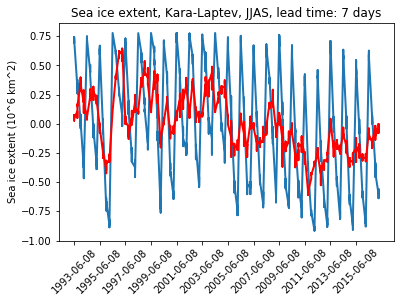

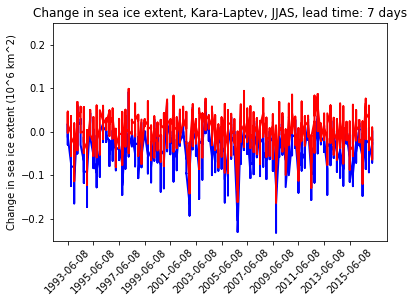

In [33]:
plt.plot(SIE_lead_sel['V (valid date)'],SIE_lead_sel['SIE']-SIE_lead_sel['SIE'].mean(),linewidth=2)
plt.plot(SIE_lead_sel['V (valid date)'],SIE_lead_sel['SIE (seas rem)'],color='r',linewidth=2)
#plt.plot(SIE_lead_sel['V (valid date)'],signal.detrend(SIE_lead_sel['SIE']),color='g',linewidth=2)
plt.ylabel('Sea ice extent (10^6 km^2)')
plt.xticks(SIE_lead_sel['V (valid date)'].iloc[np.arange(0,len(SIE_lead_sel['SIE']),200)],rotation=45)
plt.title('Sea ice extent, {region}, {season}, lead time: {lead} days'.format(region=region_name_test,season=month_sel_str,
                                                              lead=lead_days_select[lead_days_ind]))

plt.figure()
plt.plot(SIE_lead_sel['V (valid date)'],SIE_lead_sel['d_SIE (V - I)'],linewidth=2,color='b')
plt.plot(SIE_lead_sel['V (valid date)'],SIE_lead_sel['d_SIE (seas rem)'],linewidth=2,color='r')
plt.ylabel('Change in sea ice extent (10^6 km^2)')
plt.ylim(-0.25,0.25)
plt.xticks(SIE_lead_sel['V (valid date)'].iloc[np.arange(0,len(SIE_lead_sel['SIE']),200)],rotation=45)
plt.title('Change in sea ice extent, {region}, {season}, lead time: {lead} days'.format(region=region_name_test,season=month_sel_str,
                                                              lead=lead_days_select[lead_days_ind]))

Make histograms using kernel density estimates.  We'll create one for each ensemble separately.  Make a basic plot here. 

Text(0, 0.5, 'Frequency')

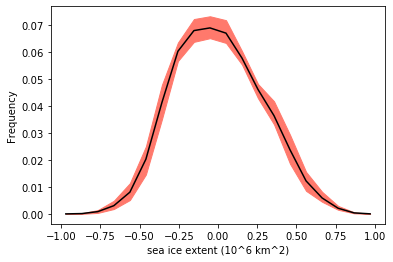

In [52]:
SIE_group_ens = SIE_lead_sel.groupby(['ensemble'])
no_ens = 25
no_bins = 20
kde_to_plot = np.empty((no_bins,0))
d_kde_to_plot = np.empty((no_bins,0))

for iens in np.arange(0,no_ens):
    ens_sel = iens + 1
    #SIE_ens_sel = SIE_group_ens['SIE'].get_group(ens_sel)
    SIE_ens_sel = SIE_group_ens['SIE (seas rem)'].get_group(ens_sel)
    d_SIE_ens_sel = SIE_group_ens['d_SIE (seas rem)'].get_group(ens_sel)
    ikde = stats.gaussian_kde(SIE_ens_sel)
    d_ikde = stats.gaussian_kde(d_SIE_ens_sel)
    bin_lims = 1.5*max(abs(SIE_ens_sel.min()),abs(SIE_ens_sel.max()))
    d_bin_lims = 1.5*max(abs(d_SIE_ens_sel.min()),abs(d_SIE_ens_sel.max()))
    #print(bin_lims)
    eval_range = np.linspace(-bin_lims,bin_lims,no_bins)
    d_eval_range = np.linspace(-d_bin_lims,d_bin_lims,no_bins)
    kde_plot = ikde.evaluate(eval_range)
    d_kde_plot = d_ikde.evaluate(d_eval_range)
    kde_to_plot = np.append(kde_to_plot,np.expand_dims(kde_plot,axis=1),axis=1)
    d_kde_to_plot = np.append(d_kde_to_plot,np.expand_dims(d_kde_plot,axis=1),axis=1)
    

plt.figure()
#plt.plot(eval_range,kde_to_plot/no_bins)
plt.fill_between(eval_range,np.amin(kde_to_plot,axis=1)/no_bins,np.amax(kde_to_plot,axis=1)/no_bins,color='xkcd:salmon')
plt.plot(eval_range,np.nanmean(kde_to_plot,axis=1)/no_bins,color='k')
plt.xlabel('sea ice extent (10^6 km^2)')
plt.ylabel('Frequency')
#plt.title()
#plt.figure()
#plt.plot(d_eval_range,d_kde_to_plot)